In [261]:
import tensorflow as tf


import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
import os

import cv2
import Augmentor as au

import unet_kkweon


from IPython import display
%matplotlib inline

In [484]:
from tqdm import tqdm, tqdm_notebook
import time

In [263]:
path = "../data/stage_1_processed/"

### Load data

In [264]:
train_names = os.listdir(path + "train")
val_names = os.listdir(path + "val")

In [408]:
train_data = [np.load(path + "train/" + name) for name in train_names]
val_data = [np.load(path + "val/" + name) for name in val_names]

In [409]:
# train_data = [np.concatenate((x,
#                               np.expand_dims(cv2.morphologyEx(x[:,:,1], cv2.MORPH_GRADIENT, np.ones((2,2))),2)), -1)\
#               for x in train_data ]

In [410]:
def norm_mask(x):
    x[:,:,1] = (x[:,:,1] == 1).astype(int)
    return x
    
def norm_im(x):
    x[:,:,0] = x[:,:,0] - x[:,:,0].min()
    x[:,:,0] = x[:,:,0] / x[:,:,0].max()
    return x

train_data = [norm_im(norm_mask(x)) for x in train_data]
val_data = [norm_im(norm_mask(x)) for x in val_data]

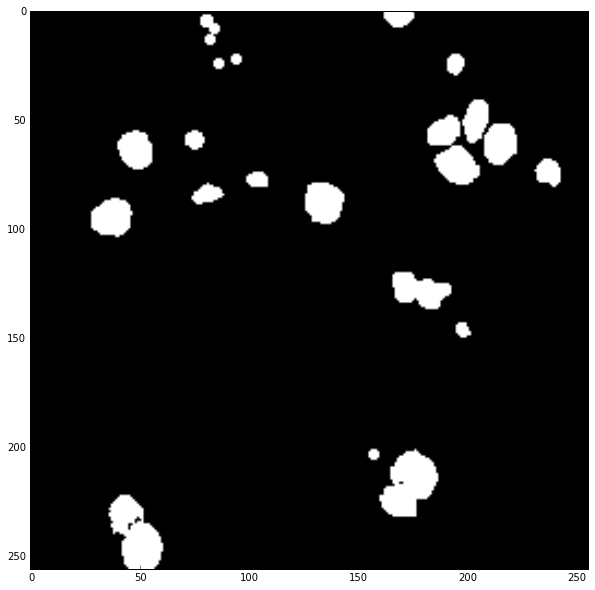

In [411]:
plt.figure(figsize = (10,10))
plt.imshow(train_data[4][:,:,1],cmap='gray')
plt.show()

### Create network and session

In [270]:
def conv_conv_pool(input_,
                   n_filters,
                   training,
                   flags,
                   name,
                   pool=True,
                   activation=tf.nn.relu):
    """{Conv -> BN -> RELU}x2 -> {Pool, optional}

    Args:
        input_ (4-D Tensor): (batch_size, H, W, C)
        n_filters (list): number of filters [int, int]
        training (1-D Tensor): Boolean Tensor
        name (str): name postfix
        pool (bool): If True, MaxPool2D
        activation: Activaion functions

    Returns:
        net: output of the Convolution operations
        pool (optional): output of the max pooling operations
    """
    net = input_

    with tf.variable_scope("layer{}".format(name)):
        for i, F in enumerate(n_filters):
            net = tf.layers.conv2d(
                net,
                F, (3, 3),
                activation=None,
                padding='same',
                #kernel_regularizer=tf.contrib.layers.l2_regularizer(flags.reg),
                name="conv_{}".format(i + 1))
            net = tf.layers.batch_normalization(
                net, training=training, name="bn_{}".format(i + 1))
            net = activation(net, name="relu{}_{}".format(name, i + 1))

        if pool is False:
            return net

        pool = tf.layers.max_pooling2d(
            net, (2, 2), strides=(2, 2), name="pool_{}".format(name))

        return net, pool


def upconv_concat(inputA, input_B, n_filter, flags, name):
    """Upsample `inputA` and concat with `input_B`

    Args:
        input_A (4-D Tensor): (N, H, W, C)
        input_B (4-D Tensor): (N, 2*H, 2*H, C2)
        name (str): name of the concat operation

    Returns:
        output (4-D Tensor): (N, 2*H, 2*W, C + C2)
    """
    up_conv = upconv_2D(inputA, n_filter, flags, name)

    return tf.concat(
        [up_conv, input_B], axis=-1, name="concat_{}".format(name))


def upconv_2D(tensor, n_filter, flags, name):
    """Up Convolution `tensor` by 2 times

    Args:
        tensor (4-D Tensor): (N, H, W, C)
        n_filter (int): Filter Size
        name (str): name of upsampling operations

    Returns:
        output (4-D Tensor): (N, 2 * H, 2 * W, C)
    """

    return tf.layers.conv2d_transpose(
        tensor,
        filters=n_filter,
        kernel_size=2,
        strides=2,
        #kernel_regularizer=tf.contrib.layers.l2_regularizer(flags.reg),
        name="upsample_{}".format(name))


def make_unet(X, training, flags=None):
    """Build a U-Net architecture

    Args:
        X (4-D Tensor): (N, H, W, C)
        training (1-D Tensor): Boolean Tensor is required for batchnormalization layers

    Returns:
        output (4-D Tensor): (N, H, W, C)
            Same shape as the `input` tensor

    Notes:
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        https://arxiv.org/abs/1505.04597
    """
    #net = X / 127.5 - 1
    net = X
    conv1, pool1 = conv_conv_pool(net, [8, 8], training, flags, name=1)
    conv2, pool2 = conv_conv_pool(pool1, [16, 16], training, flags, name=2)
    conv3, pool3 = conv_conv_pool(pool2, [32, 32], training, flags, name=3)
    conv4, pool4 = conv_conv_pool(pool3, [64, 64], training, flags, name=4)
    conv5 = conv_conv_pool(
        pool4, [128, 128], training, flags, name=5, pool=False)

    up6 = upconv_concat(conv5, conv4, 64, flags, name=6)
    conv6 = conv_conv_pool(up6, [64, 64], training, flags, name=6, pool=False)

    up7 = upconv_concat(conv6, conv3, 32, flags, name=7)
    conv7 = conv_conv_pool(up7, [32, 32], training, flags, name=7, pool=False)

    up8 = upconv_concat(conv7, conv2, 16, flags, name=8)
    conv8 = conv_conv_pool(up8, [16, 16], training, flags, name=8, pool=False)

    up9 = upconv_concat(conv8, conv1, 8, flags, name=9)
    conv9 = conv_conv_pool(up9, [8, 8], training, flags, name=9, pool=False)

    return tf.layers.conv2d(
        conv9,
        1, (1, 1),
        name='final',
        #activation=tf.nn.sigmoid,
        padding='same')


In [325]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [423]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [424]:
x = tf.placeholder("float", shape=[None, None, None, 1])
target = tf.placeholder("float", shape=[None, None, None, 1])
training = tf.placeholder('bool')

In [425]:
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (x)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

out = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [426]:
#out_logits = make_unet(x, training)

In [427]:
#out = tf.nn.sigmoid(out_logits)

In [428]:
loss = tf.reduce_mean(tf.losses.log_loss(target, out))

#loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(target, out_logits))
#loss = mean_iou(out, target)

In [429]:
optimizer = tf.train.AdamOptimizer(beta2=0.98)
train_step = optimizer.minimize(loss)

In [430]:
sess.run(tf.global_variables_initializer())

In [431]:
gr = tf.get_default_graph()

writer = tf.summary.FileWriter("../tf_logs", gr)

In [116]:
test_loss = tf.reduce_mean(tf.losses.log_loss(target, x))

In [151]:
sess.run(loss, feed_dict={x:batch_x, target:batch_y, training:0})

0.51363271

### Augmentation + batch_iterator

In [333]:
def mirror(im):
    shape = im.shape
    h = lambda arr: np.hstack((arr[:,(shape[1] // 2)::-1,:], arr, arr[:,:(shape[1] // 2):-1,:]))
    v = lambda arr: np.vstack((arr[shape[0] // 2::-1,:,:], arr, arr[:shape[0] // 2:-1,:,:]))

    return v(h(im))

In [334]:
u16_up = lambda x : int((x // 16 + 1) * 16)
u16_d = lambda x : int((x // 16) * 16)

In [335]:
def crop(im, shape=None):
    if shape is None:
        shape = (u16_d(im.shape[0] * 0.7), u16_d((im.shape[1] * 0.7)))
    #shape = (min(512, im.shape[0] - 1), min(512, im.shape[1] - 1))
    x = np.random.randint(0, im.shape[0] - shape[0])
    y = np.random.randint(0, im.shape[1] - shape[1])
    
    excerpt_x = slice(x, x+shape[0])
    excerpt_y = slice(y, y+shape[1])
    
    return im[excerpt_x, excerpt_y, :]

In [336]:
def get_16_im(im):
    shape = im.shape
    big_im = mirror(im)
    pos_x = shape[0] // 2
    pos_y = shape[1] // 2
    
    
    shape_shift = (u16_up(shape[0]), u16_up(shape[1]))
    
    #prediction = sess.run(sigmoid_out, feed_dict={x : np.expand_dims(big_im[x: x + shape_shift[0], y : y + shape_shift[1], :], 0), training : False})
    return big_im[pos_x: pos_x + shape_shift[0], pos_y : pos_y + shape_shift[1],:]

In [339]:
import revertable_augmentator as ra
from importlib import reload
ra = reload(ra)

In [340]:
def transform(im):
    transformation = ra.Transformation.generate_geometrical(mirror(im))
    return crop(transformation.apply(im))

In [341]:
def iterate_minibatches(x, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(x))
        np.random.shuffle(indices)
    for start_idx in range(0, len(x) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x[excerpt]

In [432]:
train_loss = []
val_scores = []
val_loss = []

In [433]:
epochs = 15

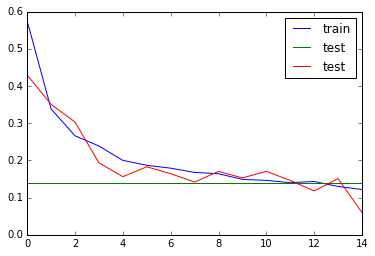

In [434]:
for epoch in range(epochs):
    curr_loss = 0
    imgs = np.array([transform(im) for im in train_data[:]])
    #imgs = np.array([im for im in train_data[:]])
    for i, (batch) in tqdm(enumerate(iterate_minibatches(imgs[:],20))):
        shapes = np.concatenate(([np.array(image.shape).reshape(1, -1) for image in batch]))
        batch_shape = (u16_d(shapes[:,0].min() - 1), u16_d(shapes[:,1].min() - 1))
        images = [crop(im, batch_shape) for im in batch]
        
        batch_x = np.concatenate([np.expand_dims(im[:,:,:1],0) for im in images], 0)
        batch_y = np.concatenate([np.expand_dims(im[:,:,1:2],0) for im in images], 0)

        
        batch_loss = sess.run([train_step,loss], feed_dict={x : batch_x, target: batch_y, training : 0})
        curr_loss += batch_loss[1]

    train_loss.append(curr_loss / (i + 1)) 
    
    val_score = validate_simple(val_data)
    
#     if epoch != 0:
#         if val_score < val_scores[-1]:
#             save_model("../model/model_1/")
            
            
    val_scores.append(val_score)
    val_loss.append(sess.run(loss, feed_dict={x:batch_x, target:batch_y, training:0}))
    
    display.clear_output(wait=True)
    plt.plot(train_loss, label='train')
    plt.plot(val_scores, label='test')
    plt.plot(val_loss, label='test')
    plt.legend()
    plt.show()
            

In [345]:
val_score = validate_simple(val_data)

44it [00:00, 711.65it/s]


In [346]:
val_score

0.13912045897554309

In [77]:
batch_y.min()

0.0

In [79]:
batch_x.max()

1.0

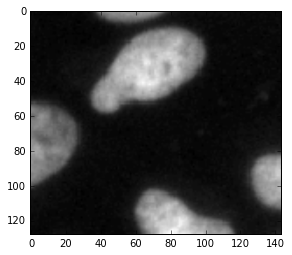

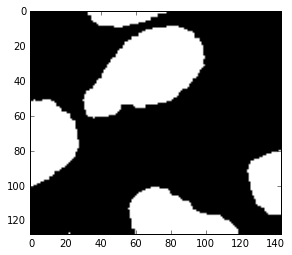

In [348]:
#pred = predict(batch_y[0])
ind = 7
plt.imshow(batch_x[ind][:,:,0], cmap = 'gray')
plt.show()
plt.imshow(batch_y[ind][:,:,0], cmap = 'gray')
plt.show()

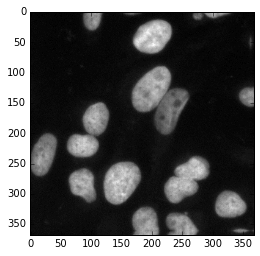

In [435]:
plt.imshow(get_16_im(val_data[3][:,:,:1])[:,:,0], cmap = 'gray')
plt.show()

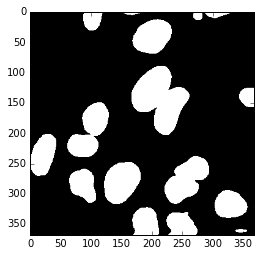

In [436]:
plt.imshow(get_16_im(val_data[3][:,:,1:2])[:,:,0], cmap = 'gray')
plt.show()

In [446]:
pred = predict(val_data[3][:,:,:1])
#pred = sess.run(out, feed_dict={x : batch_x[5:6], training : 1})[0]

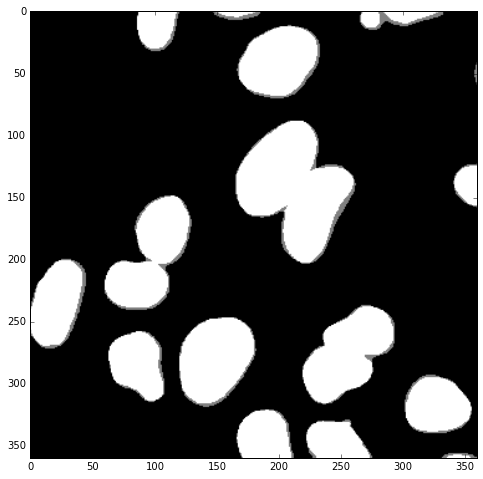

In [450]:
plt.figure(figsize = (8,8))
plt.imshow((pred[:,:] > 0.5).astype(int) + val_data[3][:,:,1:2][:,:,0], cmap = 'gray')
plt.show()

In [440]:
def predict(im):
    shape = im.shape
    im_16 = get_16_im(im)
    #im_16 = im
    prediction = sess.run(out, feed_dict={x : np.expand_dims(im_16, 0), training : 0})[0]
    #prediction = prediction.max(2)
    prediction = prediction[:,:,0]
    return cv2.morphologyEx(prediction[:shape[0],:shape[1]], cv2.MORPH_CLOSE, np.ones((3,3)))

In [652]:
def predict_resize(im, steps = 3):
    shape = im.shape
    im_16 = get_16_im(im)

    #prediction = sess.run(out, feed_dict={x : np.expand_dims(im_16, 0), training : 0})[0]
    prediction = np.zeros(shape)
    
    for i in [k for k in range(1, 1 + steps)] + [1/k for k in range(2, 1+steps)]:
        print(i)
        trnsf = ra.Transformation(im_16, ratios=np.array([1,1]) * i)
        im_resized = trnsf.apply(im_16, True)
        shape_resized = im_resized.shape
        
        im_resized_16 = get_16_im(im_resized)
        pred_resized = sess.run(out, feed_dict={x : np.expand_dims(im_resized_16, 0), training : 0})[0][:shape_resized[0],:shape_resized[1]]
        
        
        trnsf_inv = ra.Transformation(pred_resized, ratios=np.array([1,1]) / i)
        
        pred_original_shape = trnsf_inv.apply(pred_resized, False)[:shape[0],:shape[1]]
        
#         print(pred_resized.max())
#         show(pred_original_shape,0)
#         print(pred_original_shape.max())
        prediction += pred_original_shape
        
    #prediction = prediction[:,:,0]
    return prediction / (steps)

In [653]:
ra=reload(ra)

1


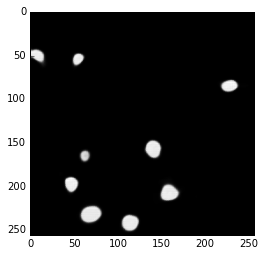

2


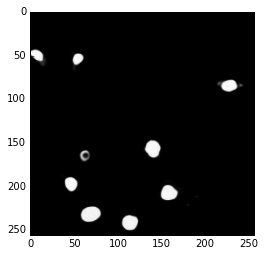

0.5


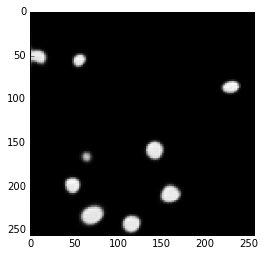

In [654]:
strange = predict_resize(val_data[0][:,:,:1],2)

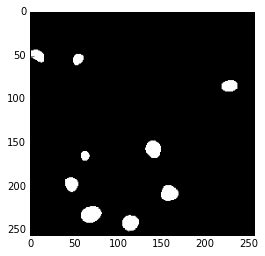

In [655]:
show(strange>0.5,0)

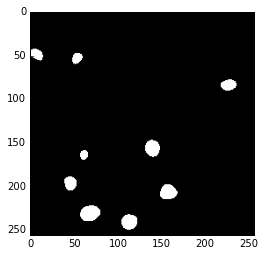

In [620]:
show(predict(val_data[0][:,:,:1]) > 0.5)

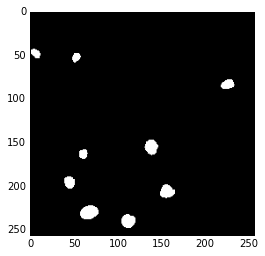

In [572]:
show(val_data[0][:,:,1])

In [573]:
val_data[0][:,:,0].max()

1.0

In [656]:
validate_simple(val_data[:10], predict)

10it [00:00, 577.81it/s]


0.67939775245345868

1


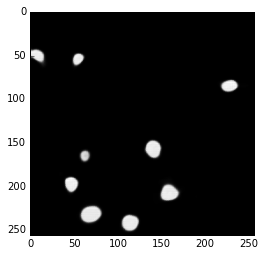

2


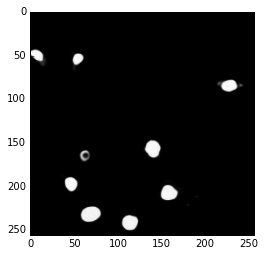

3


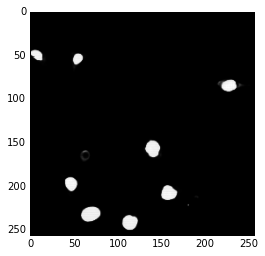

0.5


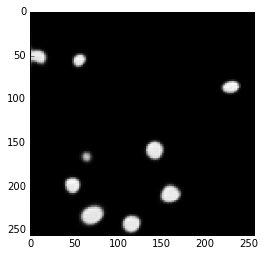

0.3333333333333333


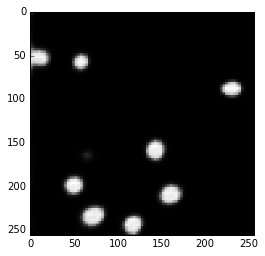

1


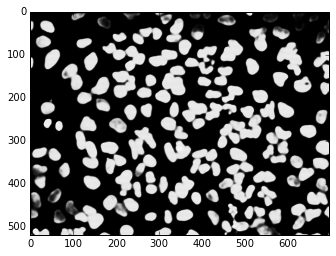

2


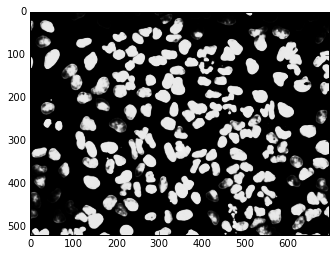

3


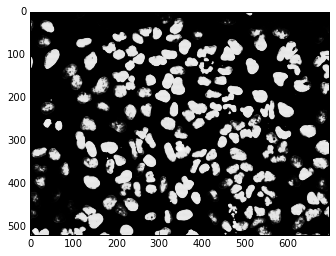

0.5


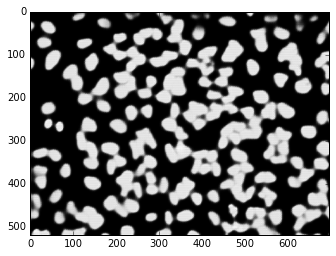

0.3333333333333333


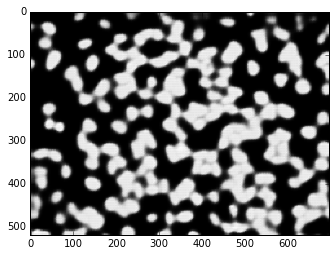

1


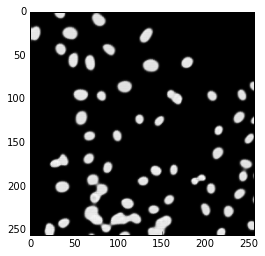

2


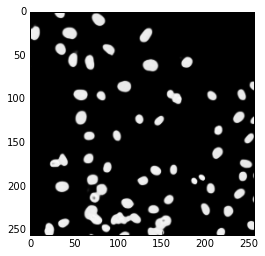

3


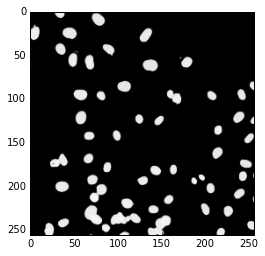

0.5


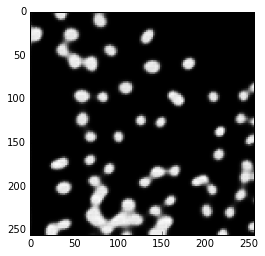

0.3333333333333333


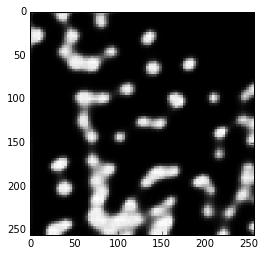

1


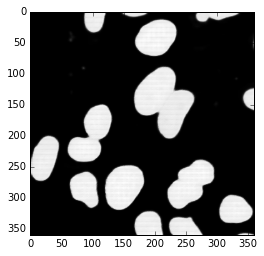

2


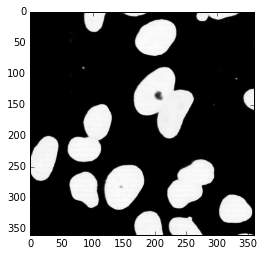

3


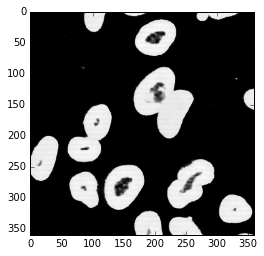

0.5


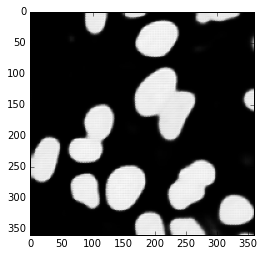

0.3333333333333333


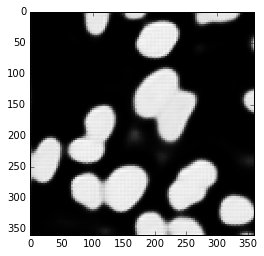

1


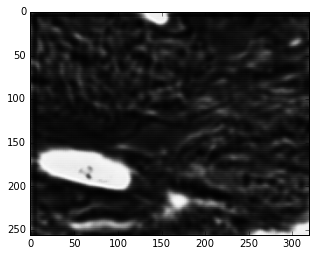

2


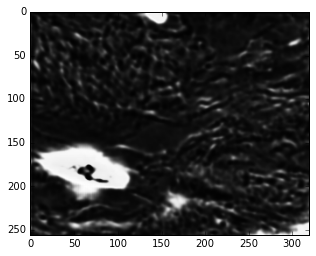

3


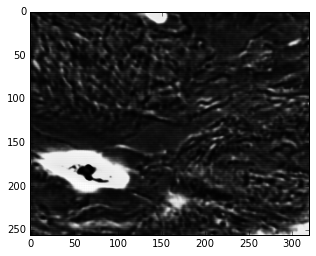

0.5


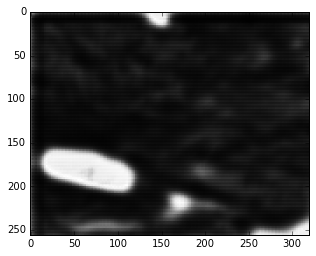

0.3333333333333333


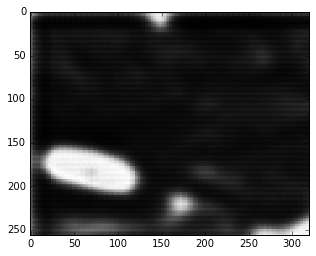

1


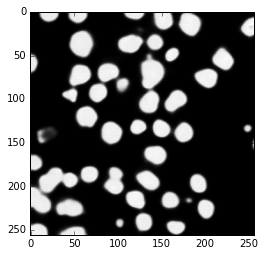

2


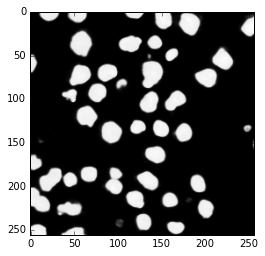

3


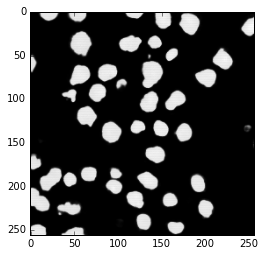

0.5


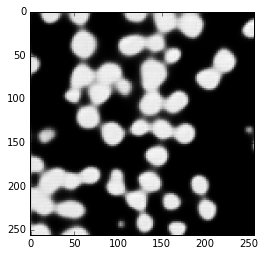

0.3333333333333333


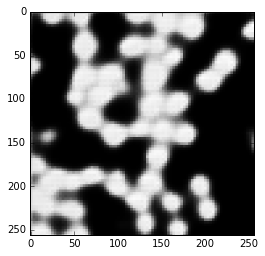

1


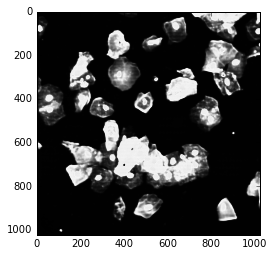

2


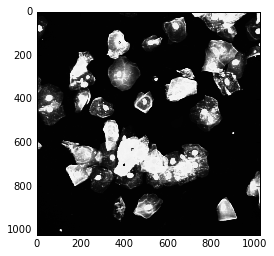

3


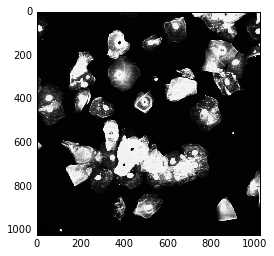

0.5


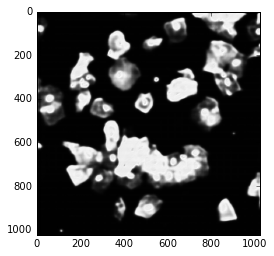

0.3333333333333333


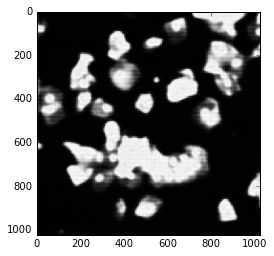

1


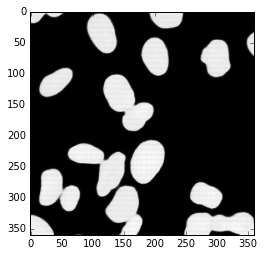

2


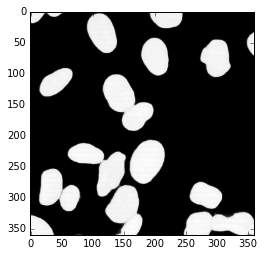

3


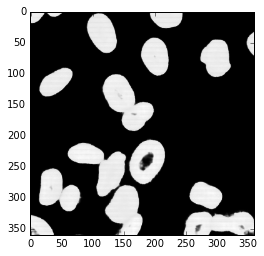

0.5


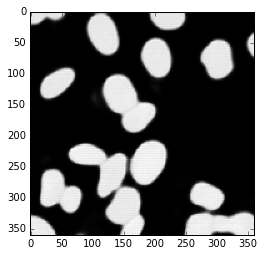

0.3333333333333333


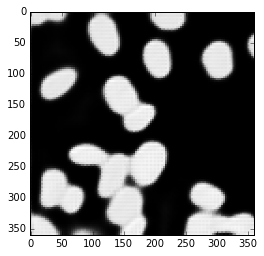

1


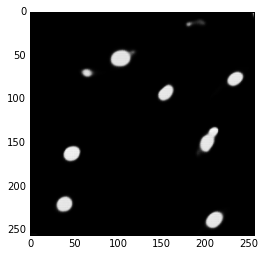

2


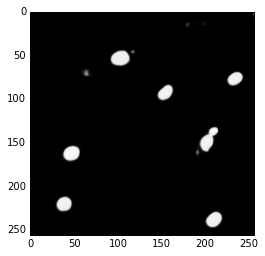

3


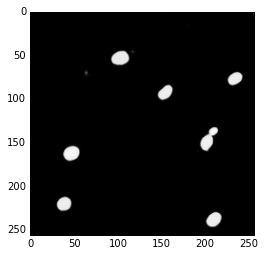

0.5


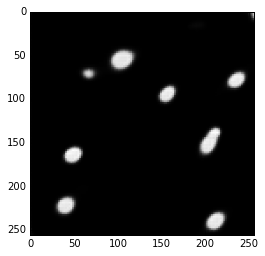

0.3333333333333333


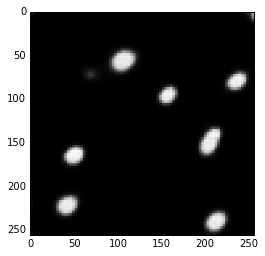

1


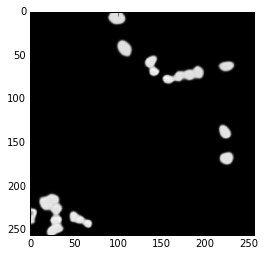

2


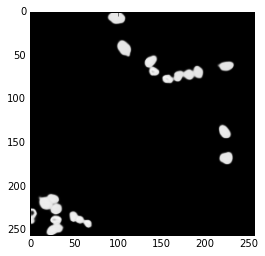

3


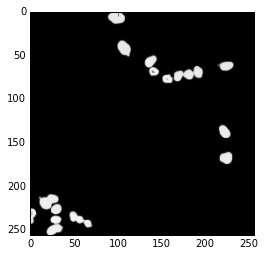

0.5


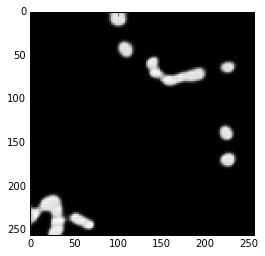

0.3333333333333333


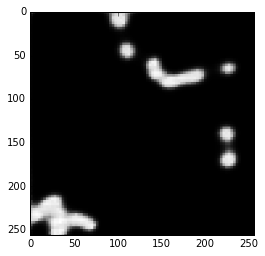

1it [00:00,  6.97it/s]


ValueError: operands could not be broadcast together with shapes (520,696,1) (520,696,1,1) 

In [657]:
validate_simple(val_data[:10], predict_resize)

In [529]:
strange.max()

0.0047676763113807235

In [487]:
def validate(data):
    predictions = [np.expand_dims(predict(im[:,:,:1]), 2) for im in data]
    ground_truth = [im[:,:,1:2] for im in data]
    
    MAP = 0
    for t,p in tqdm_notebook(zip(ground_truth, predictions)):
        MAP += calculate_average_precision([x for x in prob_to_masks(t)], [x for x in prob_to_masks(p)])
    
    return MAP / len(predictions)

In [552]:
def validate_simple(data, prediction_func, cut_off=0.5):
    predictions = [np.expand_dims(prediction_func(im[:,:,:1]), 2) for im in data]
    ground_truth = [im[:,:,1:2] for im in data]
    
    IOU = 0
    for t,p in tqdm(zip(ground_truth, predictions)):
        #MAP += calculate_average_precision([x for x in prob_to_masks(t)], [x for x in prob_to_masks(p)])
        IOU += np.logical_and(t,p > cut_off).sum() / np.logical_or(t,p > cut_off).sum()

    return IOU / len(predictions)

In [486]:
validate(val_data[:2])

2it [00:34, 17.01s/it]


0.37292384131620637

In [48]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)
        
def prob_to_masks(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield (lab_img==i).astype(int)

In [485]:
def iou_at_thresholds(target_mask, pred_mask, thresholds=np.arange(0.5,1,0.05)):
    '''Returns True if IoU is greater than the thresholds.'''
    intersection = np.logical_and(target_mask, pred_mask)
    union = np.logical_or(target_mask, pred_mask)
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    return iou > thresholds

def calculate_average_precision(target_masks, pred_masks, thresholds=np.arange(0.5,1,0.05)):
    '''Calculates the average precision over a range of thresholds for one observation (with a single class).'''
    iou_tensor = np.zeros([len(thresholds), len(pred_masks), len(target_masks)])

    for i, p_mask in (enumerate(pred_masks)):
        for j, t_mask in enumerate(target_masks):
            iou_tensor[:, i, j] = iou_at_thresholds(t_mask, p_mask, thresholds)

    TP = np.sum((np.sum(iou_tensor, axis=2) == 1), axis=1)
    FP = np.sum((np.sum(iou_tensor, axis=1) == 0), axis=1)
    FN = np.sum((np.sum(iou_tensor, axis=2) == 0), axis=1)

    precision = TP / (TP + FP + FN)

    return np.mean(precision)

In [468]:
def show(im, i = None, figsize =None):
    if len(im.shape) == 3:
        to_show = im[:,:,i]
    else:
        to_show = im
        
    if not figsize is None:
        plt.figure(figsize=(figsize))
    plt.imshow(to_show, cmap='gray')
    plt.show()
    

In [300]:
for val_im in tqdm(val_data[1:2]):
    prediction = sess.run(out, feed_dict={x : np.expand_dims(get_16_im(val_im[:,:,:1]), 0), training : False})
    mask = prediction[0][:val_im.shape[0],:val_im.shape[1],:1]
    mask_int = (mask > 0.5).astype(int)[:,:,0].astype('uint8')
    iou = (mask_int == val_im[:,:,1]).sum() / (val_im[:,:,1].shape[0] * val_im[:,:,1].shape[1])

100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


In [301]:
mask_int == val_im[:,:,1]

array([[ True,  True, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [302]:
iou

0.33909980106100795

In [340]:
val_data[0]

214

In [425]:
im = val_data[0][:,:,:]
prediction = sess.run(out, feed_dict={x : np.expand_dims(get_16_im(im[:,:,:1]), 0), training : False})

In [426]:
mask = prediction[0][:im.shape[0],:im.shape[1],:1]

In [427]:
#(mask == im[:,:,1]).sum() / (mask.shape[0] * mask.shape[1])

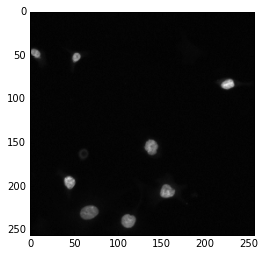

In [428]:
# n = next(gens[3])
# im = random_select(n[0][0])
#im = n[0][0]
plt.imshow(im[:,:,0], cmap='gray')
plt.show()

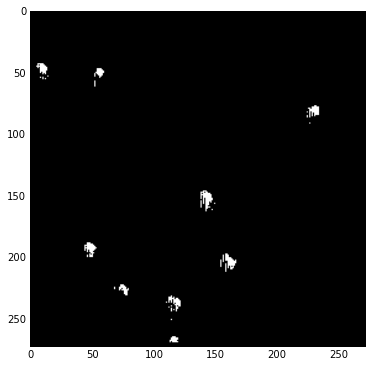

In [429]:
plt.figure(figsize=(6,6))
plt.imshow((prediction[0,:,:,0] > 0.5).astype(float), cmap='gray')
plt.show()

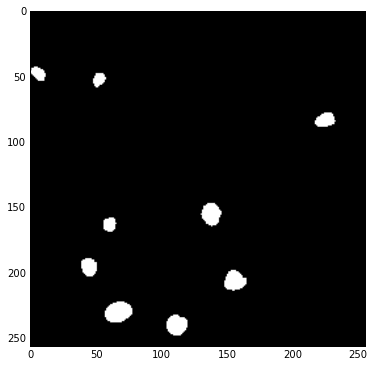

In [430]:
plt.figure(figsize=(6,6))
plt.imshow(im[:,:,1], cmap='gray')
plt.show()

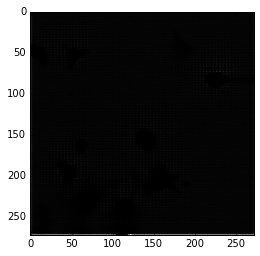

In [400]:
# n = next(gens[3])
# im = random_select(n[0][0])
#im = n[0][0]
plt.imshow((prediction[0,:,:,0] ).astype(float), cmap='gray')
plt.show()

In [397]:
(prediction[0,:,:,0] < 1).sum()

73984

In [399]:
prediction[0,:,:,0]

array([[ 0.23792891,  0.18138488,  0.17746097, ...,  0.11622853,
         0.14882194,  0.31160143],
       [ 0.19506824,  0.14958581,  0.07271095, ...,  0.02649408,
         0.07109028,  0.34236488],
       [ 0.1125815 ,  0.12523165,  0.02593599, ...,  0.02148531,
         0.05426122,  0.22604905],
       ..., 
       [ 0.18813436,  0.17537072,  0.02569957, ...,  0.03841708,
         0.05215421,  0.23445144],
       [ 0.28400499,  0.15761682,  0.05214234, ...,  0.11246896,
         0.11453896,  0.50444877],
       [ 0.36271894,  0.2885918 ,  0.28259546, ...,  0.47109088,
         0.45756462,  0.71003157]], dtype=float32)

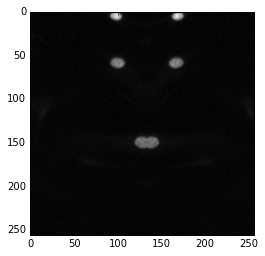

In [201]:
plt.imshow(batch_x[15][:,:,0], cmap='gray')
plt.show()

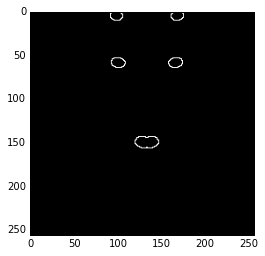

In [202]:
plt.imshow(batch_y[15][:,:,0], cmap='gray')
plt.show()

In [197]:
batch_y.shape

(20, 256, 256, 1)

In [204]:
batch_y.min()

0

In [444]:
val_data[0].shape

(360, 360, 2)

In [415]:
batch_y.shape

(3, 511, 511, 2)

In [411]:
np.expand_dims(np.concatenate(batch_x), 3).shape

(3, 511, 511, 1)

In [405]:
images[0].shape

(511, 511, 3)

In [436]:
batch_y[2][:,:,0]

array([[  0,   0,   0, ..., 255, 255, 254],
       [  0,   0,   0, ..., 255, 255, 254],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [428]:
batch_x[0].shape

(256, 256, 1)

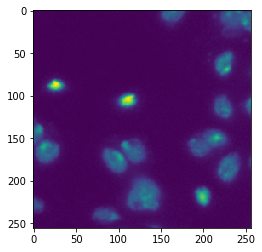

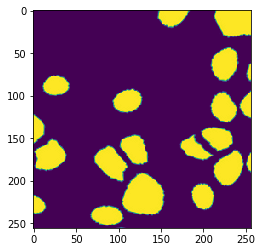

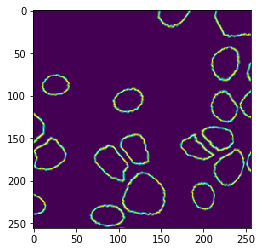

In [435]:
# n = next(gens[3])
# im = random_select(n[0][0])
#im = n[0][0]
plt.imshow(batch_x[2][:,:,0])
plt.show()
plt.imshow(batch_y[2][:,:,0])
plt.show()
plt.imshow(batch_y[2][:,:,1])
plt.show()

In [366]:
im[:,:,1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

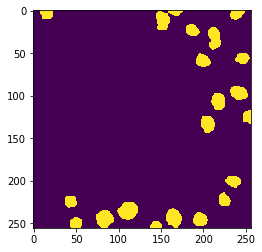

In [247]:
plt.imshow(val_data[23][:,:,1])
plt.show()

In [61]:
gr = tf.get_default_graph()
#gr = sess.graph
#gr = tf.get_default_session().graph

writer = tf.summary.FileWriter("../tf_logs", gr)

# generic unet :)

In [13]:
import tf_unet.unet as unet_module
unet_module = reload(unet_module)

In [11]:
with sess.as_default():
    unet = unet_module.Unet(channels=1)

2018-04-08 15:11:02,022 Layers 3, features 16, filter size 3x3, pool size: 2x2


In [20]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [21]:
x = tf.placeholder("float", shape=[None, None, None, 1])
y = tf.placeholder("float", shape=[None, None, None, 2])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
        
logits, variables, offset = unet_module.create_conv_net(x, keep_prob, 1, 2)

2018-04-08 15:15:32,235 Layers 3, features 16, filter size 3x3, pool size: 2x2


In [22]:
sess.run(tf.global_variables_initializer())

In [28]:
x_ = np.zeros((1,100,100,1))


In [29]:
sess.run(logits, feed_dict={x : x_, keep_prob : 1}).shape

(1, 160, 160, 2)

In [68]:
#loss = tf.reduce_mean(categorical_crossentropy(target, inp))
loss = tf.reduce_mean(tf.losses.mean_squared_error(target, out))

In [69]:
optimizer = tf.train.AdamOptimizer()
train_step = optimizer.minimize(loss)